# Homework 1

В этой домашке вам предстоит практически с нуля реализовать многие алгоритмы, о которых мы говорили на лекциях. 

Всего за домашку можно получить 80 баллов. В каждом пункте домашки указан максимум баллов, который можно получить за этот пункт.

In [90]:
# импортируем нужные библиотеки
from __future__ import print_function

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from time import time
from skimage import io

from tqdm import tqdm

%matplotlib inline
plt.rcParams['figure.figsize'] = (15.0, 12.0) # размер изображений по умолчанию
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

## Canny Edge Detector 

Ваша задача - сделать свой свобствеенный Canny edge detector. Алгоритм будет состоять из 5 частей:
1. Сглаживание (smoothing)
2. Вычисление градиентов
3. Non-maximum suppression
4. Двойной порог (double thresholding)
5. Гистерезис (анализ связности)

### 1.1 Smoothing  (10 баллов)

Сглаживание происходит за счет свертки входной изображений с ядром Гаусса. Ядро Гаусса размера $(2k+1)\times(2k+1)$ задается уравнением:

$$h_{ij}=\frac{1}{2\pi\sigma^2}\exp{\Bigl(-\frac{(i-k)^2+(j-k)^2}{2\sigma^2}\Bigr)}, 0\leq i,j < 2k+1$$

Также для дальнейшей работы нам понадобится функция свертки. 

Имплементируйте функции **`conv`** и **`gaussian_kernel`**.

In [2]:
def conv(image, kernel):
    """ Функция свертки

    Эта функция использует поэлементное умножение и метод np.sum() 
    для эффективного вычисления суммы соседних пикселей для каждого пикселя.

    Args:
        image: numpy array of shape (Hi, Wi).
        kernel: numpy array of shape (Hk, Wk).

    Returns:
        out: numpy array of shape (Hi, Wi).
    """
    Hi, Wi = image.shape
    Hk, Wk = kernel.shape
    out = np.zeros((Hi, Wi))

    # В данном задании будут использоваться значения граничных пикселей для паддинга изображений (edge padding)
    # Zero padding сделает значения градиента слишком большими на краях изображения
    pad_width0 = Hk // 2
    pad_width1 = Wk // 2
    pad_width = ((pad_width0,pad_width0),(pad_width1,pad_width1))
    padded = np.pad(image, pad_width, mode='edge')

    for i in range(Hi):
        for j in range(Wi):
            out[i][j] = np.sum(padded[i:i+Hk, j:j+Wk]*kernel)           

    
    

    return out

def gaussian_kernel(size, sigma):
    """ Ядро Гаусса

    Эта функция использует формулу ядра Гаусса и возвращает соответствующую матрицу свертки
     
    Подсказка:
    - Используйте np.pi и np.exp, чтобы посчитать число pi и экспоненту.

    Args:
        size: int of the size of output matrix.
        sigma: float of sigma to calculate kernel.

    Returns:
        kernel: numpy array of shape (size, size).
    """
    # identity
    # kernel = np.array([[0,0,0],[0,1,0],[0,0,0]])

    ax = np.arange(-size // 2 + 1., size // 2 + 1.)
    xx, yy = np.meshgrid(ax, ax)
    e = np.float32((xx**2 + yy**2) / (2. * sigma**2.))
    kernel = 1. / ((sigma**2.) * (2. * np.pi)) * np.exp(-e)
    return kernel

In [3]:
gaussian_kernel(3,1)

array([[0.05854983, 0.09653235, 0.05854983],
       [0.09653235, 0.15915494, 0.09653235],
       [0.05854983, 0.09653235, 0.05854983]], dtype=float32)

In [4]:
# Вручную определим 3x3 ядро Гаусса с std = 1
kernel = gaussian_kernel(3, 1)
kernel_test = np.array(
    [[ 0.05854983, 0.09653235, 0.05854983],
     [ 0.09653235, 0.15915494, 0.09653235],
     [ 0.05854983, 0.09653235, 0.05854983]]
)

# Небольшая проверка
if not np.allclose(kernel, kernel_test):
    print('Неправильно! Проверьте еще раз, как работает ваша функция.')

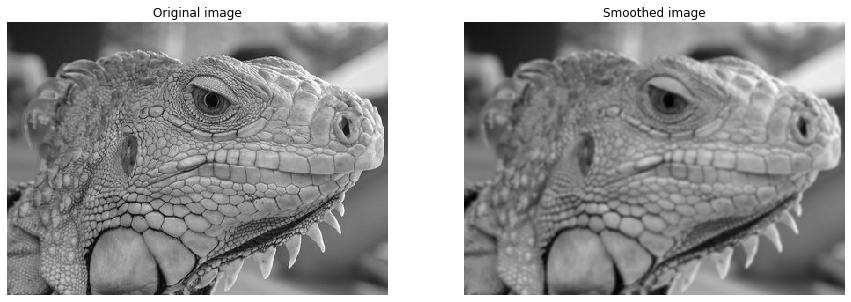

In [5]:
# Еще одна проверка
kernel_size = 5
sigma = 1.4

# Загружаем изображени
img = io.imread('iguana.png', as_gray=True)

# Находим 5x5 ядро Гаусса с std = sigma
kernel = gaussian_kernel(kernel_size, sigma)

# Делаем свертку изображения по ядру Гаусса, чтобы добиться эффекты размытия 
# (и избавиться от шума конечно)
smoothed = conv(img, kernel)

plt.subplot(1,2,1)
plt.imshow(img)
plt.title('Original image')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(smoothed)
plt.title('Smoothed image')
plt.axis('off')

plt.show()

### 1.2 Нахождение градиентов (15 баллов)
Градиент двумерной скалярной функции $I:\mathbb{R}^2\rightarrow{\mathbb{R}}$ задается формулой:

$$\nabla{I(x,y)}=\bigl[\frac{\partial{I}}{\partial{x}},\frac{\partial{I}}{\partial{y}}\bigr],$$

где

$$
\frac{\partial{I(x,y)}}{\partial{x}}=\lim_{\Delta{x}\to{0}}\frac{I(x+\Delta{x},y)-I(x,y)}{\Delta{x}} \\
\frac{\partial{I(x,y)}}{\partial{y}}=\lim_{\Delta{y}\to{0}}\frac{I(x,y+\Delta{y})-I(x,y)}{\Delta{y}}.
$$

При работе с изображениями (да и вообще любой дискретной функции) мы можем аппроксимировать частные производные, используя разницу значений соседних пикселей:

$$
\frac{\partial{I(x,y)}}{\partial{x}}\approx{\frac{I(x+1,y)-I(x-1,y)}{2}} \\
\frac{\partial{I(x,y)}}{\partial{y}}\approx{\frac{I(x,y+1)-I(x,y-1)}{2}}
$$

Частные производные могут быть получены путем свертки изображения $I$ с ядрами $D_x$ и $D_y$:

$$
\frac{\partial{I}}{\partial{x}}\approx{I*D_x}=G_x \\
\frac{\partial{I}}{\partial{y}}\approx{I*D_y}=G_y
$$

На лекции мы разбирали, какими должны быть $D_x$ и $D_y$.

Найдите ядра $D_x$ и $D_y$ и имплементируйте функции **`partial_x`** и **`partial_y`**, используя уже написанную функцию свертки `conv`.

In [6]:
from scipy import signal

def partial_x(img):
    """ Вычисляет частную производную входного изображения по х.

    Args:
        img: numpy array of shape (H, W).
    Returns:
        out: x-derivative image.
    """

    H, W = img.shape
    out = np.zeros((H,W))
    conv = 0.5*np.array([[1., 0., -1.]])
    out = signal.convolve2d(img, conv, boundary='fill', mode='same')    
    
    return out

def partial_y(img):
    """ Вычисляет частную производную входного изображения по y.

    Args:
        img: numpy array of shape (H, W).
    Returns:
        out: y-derivative image.
    """

    H, W = img.shape
    out = np.zeros((H,W))
    conv = 0.5*np.array([[1.], 
                        [0.], 
                        [-1.]])
    out = signal.convolve2d(img, conv, boundary='fill', mode='same')  

    return out

In [7]:
# Проверяем, что все работает хорошо

# Это вход
I = np.array(
    [[0, 0, 0],
     [0, 1, 0],
     [0, 0, 0]]
)

# Это правильный выход
I_x_test = np.array(
    [[ 0, 0, 0],
     [ 0.5, 0, -0.5],
     [ 0, 0, 0]]
)

I_y_test = np.array(
    [[ 0, 0.5, 0],
     [ 0, 0, 0],
     [ 0, -0.5, 0]]
)

# Теперь посчитаем частные производные с помощью написанных функций
I_x = partial_x(I)
I_y = partial_y(I)

# Если все правильно, тут не вылезет ошибка
if not np.all(I_x == I_x_test):
    print('partial_x incorrect')
    
if not np.all(I_y == I_y_test):
    print('partial_y incorrect')

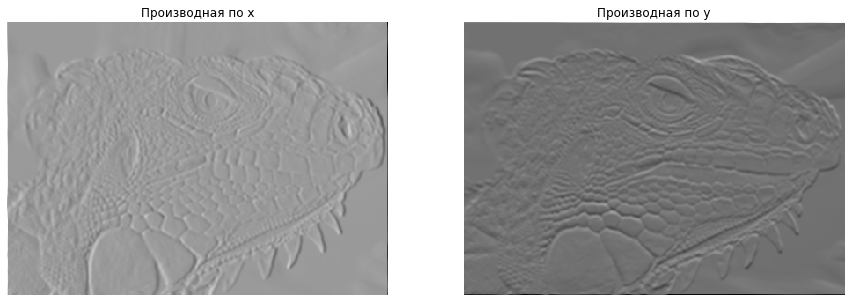

In [8]:
# Вычисляем частные производные сглаженного изображения
Gx = partial_x(smoothed)
Gy = partial_y(smoothed)

plt.subplot(1,2,1)
plt.imshow(Gx)
plt.title('Производная по x')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(Gy)
plt.title('Производная по y')
plt.axis('off')

plt.show()


Теперь, зная частные производные, мы можем вычислить магнитуду и направление градиента:

$$
G = \sqrt{G_{x}^{2}+G_{y}^{2}} \\
\Theta = arctan\bigl(\frac{G_{y}}{G_{x}}\bigr)
$$

Реализуйте функцию **`gradient`** которая принимает на вход изображение и возвращает матрицы $G$ and $\Theta$.

In [9]:
def gradient(img):
    
    """ Возвращает магнитуду и направление градиента входного изображения.
    Args:
        img: Grayscale image. Numpy array of shape (H, W).

    Returns:
        G: Magnitude of gradient at each pixel in img.
            Numpy array of shape (H, W).
        theta: Direction(in degrees, 0 <= theta < 360) of gradient
            at each pixel in img. Numpy array of shape (H, W).

    Подсказки:
        - Используйте функции np.sqrt и np.arctan2, чтобы посчитать квадратный корень и арктангенс.
    """
    G = np.zeros(img.shape)
    theta = np.zeros(img.shape)

    Gx = partial_x(img)
    Gy = partial_y(img)

    G = np.sqrt(Gx**2 + Gy**2)
    theta = np.arctan2(Gy, Gx)*180 / np.pi
    theta = theta + (theta < 0).astype(int)*360
    
    return G, theta

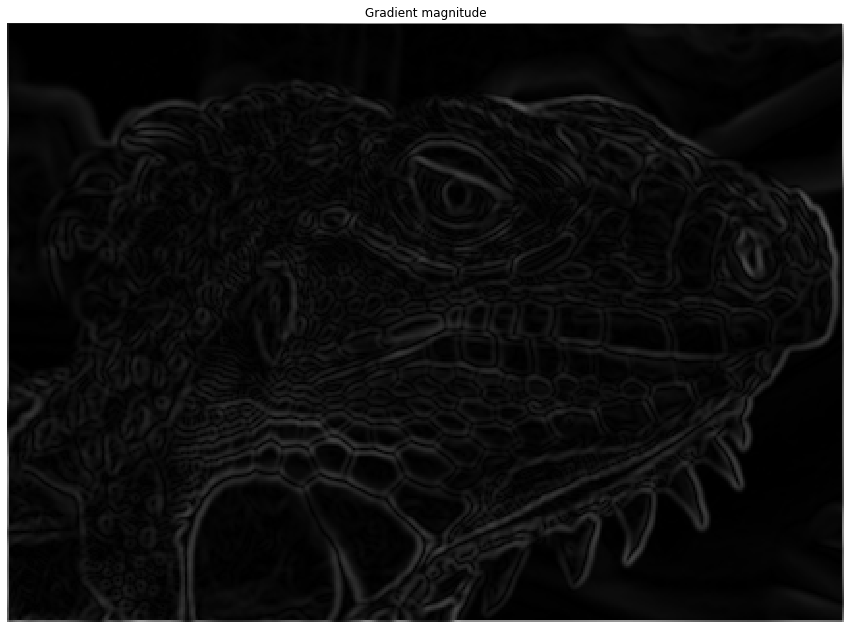

In [10]:
G, theta = gradient(smoothed)

if not np.all(G >= 0):
    print('Магнитуда в каждом пикселе должна быть больше или равна нулю')
    
if not np.all((theta >= 0) * (theta < 360)):
    print('Направление градиента должно находиться в диапозона от 0 до 360 градусов')

plt.imshow(G)
plt.title('Gradient magnitude')
plt.axis('off')
plt.show()


### 1.3 Non-maximum suppression (15 баллов)

Границы, полученные на сглаженном изображении, довольно толстые и размытые. Цель следующего шага - сделать из толстых границ тонкие ("толщиной в один пиксель"). Этого можно достичь путем нахождения локальных максимумов в матрице градиентов - мы оставляем только локальные максимумы, остальное убираем. 

Давайте рассмотрим некоторый пиксель (x,y) из матрицы градиентов. Для него алгоритм будет таков: 

1. Округлить направление градиента $\Theta[y,x]$ до ближайшего направления кратного 45 градусам (это 0, 45, 90, 135 и т. д.). Тогда нам не потребуется экстраполяция, и можно будет просто смотреть на значения одного из восьми соседних пикселей. 

2. Сравнить магнитуду градиента текущего пикселя с градиентом 2 соседних пикселей (один в положительном направлении градиента текущего пикселя, другой - в отрицательном). Например, если theta=45 градусов, надо сравнить текущий пиксель со значениями правого верхнего и левого нижнего пикселя. 

3. Если магнитуда текущего пикселя больше соседей - этот пиксель хорошая граница, ничего не нужно трогать. Иначе - занулить значения пикселя. 

Имплементируйте функцию **`non_maximum_suppression`**.

`iguana_non_max_suppressed.npy` - правильный результат работа данного алгоритма для изображения с игуаной. Используйте его для проверки корректноcти работы вашего алгоритма. Если вы видите белые пятна в изображении разности (Difference) - что-то не так.

*-Примечание: На лекции мы обсуждали, что лучше не округлять направление градиента, а вместо этого экстраполировать соседние пиксели, и сравнивать текущее значение с "мнимыми" экстраполированными пикселями. Здесь для простоты мы этого делать не будем.*

In [11]:
def non_maximum_suppression(G, theta):
    """ Удаление лишних границ с помощью non-maximum suppression.

    Функция осуществляет non-maximum suppression, используя направление градиента (theta) 
    и магнитуду градиента (G).

    Args:
        G: gradient magnitude image with shape of (H, W).
        theta: direction of gradients with shape of (H, W).

    Returns:
        out: non-maxima suppressed image.
    """
    H, W = G.shape
    out = np.zeros((H, W))

    # Округление до ближайшего значения направления кратного 45
    theta = np.floor((theta + 22.5) / 45) * 45

    cases = {
                0.0     : ((0,1),(0,-1)),
                45.0    : ((1,1),(-1,-1)),
                90.0    : ((1,0),(-1,0)),
                135.0   : ((1,-1),(-1,1)),
                180.0   : ((0,1),(0,-1)),
                225.0   : ((1,1),(-1,-1)),
                270.0   : ((1,0),(-1,0)),
                315.0   : ((1,-1),(-1,1)),
                360.0   : ((0,1),(0,-1))
    }


    pad_width0 = 1
    pad_width1 = 1
    pad_width = ((pad_width0,pad_width0),(pad_width1,pad_width1))
    padded = np.pad(G, 
                    pad_width
                    , mode='edge'
                    )

    # print(G.shape, out.shape, padded.shape)

    for i in range(H):
        for j in range(W):
            offset1, offset2 = cases[theta[i,j]]
            if  padded[i + pad_width0 + offset1[0], j + pad_width1 + offset1[1]] > padded[i+pad_width0, j+pad_width1]:
                out[i,j] = 0
            elif  padded[i+pad_width0 + offset2[0], j + pad_width1 + offset2[1]] > padded[i+pad_width0,j+pad_width1]:
                out[i,j] = 0
            else:
                out[i,j] = G[i,j]


    return out

In [12]:
# Проверяем!
g = np.array(
    [[0.4, 0.5, 0.6],
     [0.3, 0.5, 0.7],
     [0.4, 0.5, 0.6]]
)

# Игрушечный пример
# Проверка для различных значений theta
for angle in range(0, 180, 45):
    print('Thetas:', angle)
    t = np.ones((3, 3)) * angle # инициализируем theta
    print(non_maximum_suppression(g, t))

Thetas: 0
[[0.  0.  0.6]
 [0.  0.  0.7]
 [0.  0.  0.6]]
Thetas: 45
[[0.  0.  0. ]
 [0.  0.  0.7]
 [0.  0.  0.6]]
Thetas: 90
[[0.4 0.5 0. ]
 [0.  0.5 0.7]
 [0.4 0.5 0. ]]
Thetas: 135
[[0.  0.  0.6]
 [0.  0.  0.7]
 [0.  0.  0. ]]


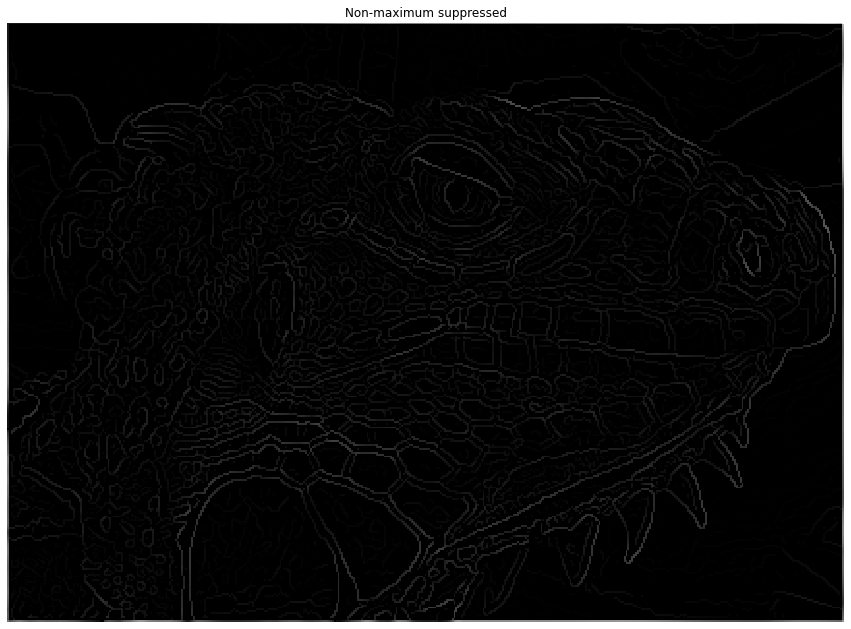

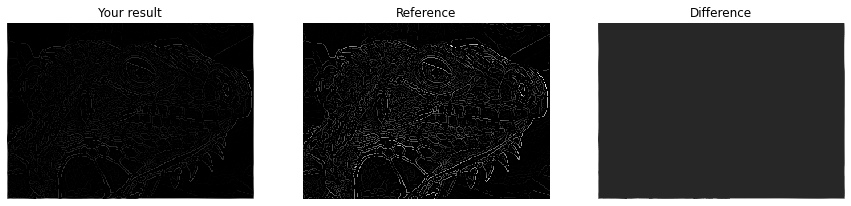

In [13]:
nms = non_maximum_suppression(G, theta)
plt.imshow(nms)
plt.title('Non-maximum suppressed')
plt.axis('off')
plt.show()

plt.subplot(1, 3, 1)
plt.imshow(nms)
plt.axis('off')
plt.title('Your result')

plt.subplot(1, 3, 2)
reference = np.load('references/iguana_non_max_suppressed.npy')
plt.imshow(reference)
plt.axis('off')
plt.title('Reference')

plt.subplot(1, 3, 3)
plt.imshow(nms - reference)
plt.title('Difference')
plt.axis('off')
plt.show()

### 1.4  Двойной порог (20 баллов)

Многие из пикселей, оставшихся после non-maximum suppression, действительно соответствуют границам объектов на изображении, а некоторые - нет (они появились, например, из-за шума или небольшого изменения цвета). 
Мы хотим получить некоторую бинарную матрицу: если значение в пикселе равно 1 - это граница, если 0 - не граница. Самый простым способ сделать это - использовать некоторый порог, т.е только те пиксели, в которых магнитуда больше  значения порога, будут являться границей. 
В детекторе Кэнни используется двойной порог. Пиксели, в которых магнитуда больше Высокого порога, будут отмечены как strong-edge-pixel. Пиксели, в которых магнитуда меньше Низкого порога - игнорируются. Пиксели, в которых магнитуда больше Низкого порога, но меньше Высокого, помечаются как weak-edge-pixel.

Имплементируйте функцию **`double_thresholding`**. 

*Note*: не меняйте значения высокого и низкого порога.

In [14]:
arr = np.array([  [1,2,3],
            [4,5,6],
            [7,8,9]])
np.logical_and((arr > 2), (arr < 4))

array([[False, False,  True],
       [False, False, False],
       [False, False, False]])

In [15]:
def double_thresholding(img, high, low):
    """ Процедура double_thresholding
    
    На вход функция принимает значения магнитуды градиентов после non-maximum suppression. 
    Возвращает 2 бинарных матрицы - strong-edge-pixels, и weak-edge-pixels. 
    
    Args:
        img: numpy array of shape (H, W) representing NMS edge response.
        high: high threshold(float) for strong edges.
        low: low threshold(float) for weak edges.

    Returns:
        strong_edges: Boolean array representing strong edges.
            Strong edeges are the pixels with the values greater than
            the higher threshold.
        weak_edges: Boolean array representing weak edges.
            Weak edges are the pixels with the values smaller or equal to the
            higher threshold and greater than the lower threshold.
    """

    # strong_edges = np.zeros(img.shape, dtype=np.bool)
    # weak_edges = np.zeros(img.shape, dtype=np.bool)

    strong_edges = (img > high)
    weak_edges = np.logical_and((img > low), (img < high))

    return strong_edges, weak_edges

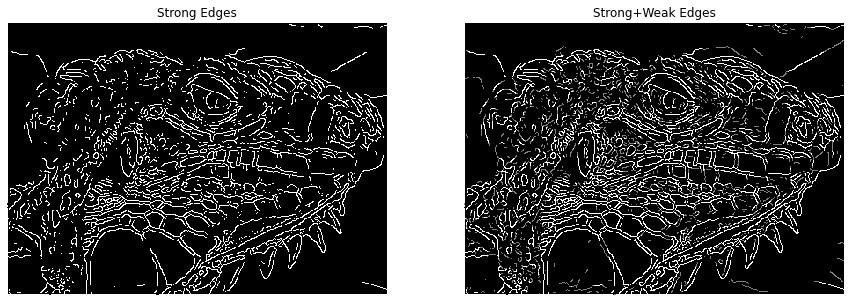

In [16]:
low_threshold = 0.02
high_threshold = 0.03

strong_edges, weak_edges = double_thresholding(nms, high_threshold, low_threshold)
assert(np.sum(strong_edges & weak_edges) == 0) #нельзя чтобы какой-то пиксель был помечен и как strong-edge, и как weak-edge
edges=strong_edges * 1.0 + weak_edges * 0.5

plt.subplot(1,2,1)
plt.imshow(strong_edges)
plt.title('Strong Edges')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(edges)
plt.title('Strong+Weak Edges')
plt.axis('off')

plt.show()

### 1.5 Гистерезис (15 баллов)

Strong-edges-пиксели - это уже точно границы, их можно сразу включить в итоговое изображение с границами. Weak-edge-пиксели включаются в итоговое изображение с границами в том и только том случае, если они соединены с сильными пикселями. Логика следующая: шум и другие небольшие пертурбации вряд ли создадут strong-edge-пиксель (если используются правильные значения порогов). Следовательно, strong-edge-пиксели всегда будут соотвествовать истинным границам объектов в исходном изображений. В то же время weak-edge-pixel могут соответствовать как и истинным границам объектов, так и различным шумам. Шум распределен равномерно по изображению, и никак не коррелирует с границами. Поэтому слабые границы, соответствующие истинным границам объектов, будут почти наверняка соединены с сильными границами.


Имплементируйте функцию **`link_edges`**.

Вам предоставлен корректный результат работы данного алгоритма (`iguana_edge_tracking.npy`) - проверяйте, все ли у вас правильно! 

In [91]:
def get_neighbors(y, x, H, W):
    """ Функция, возвращающая для пикселя (y, x) индексы его соседних пикселей .
    
    Возвращает индексы всех возможных соседей пикселя (y, x) из изображения размера (H, W). 
    Индекс корректного соседнего пикселя (i, j) должен удовлетворять 3 условиям:
        1. i >= 0 и i < H
        2. j >= 0 и j < W
        3. (i, j) != (y, x)
    
    Здесь ничего не нужно дописывать, данная функция уже работает корректно.
    
    Args:
        y, x: location of the pixel.
        H, W: size of the image.
    Returns:
        neighbors: list of indices of neighboring pixels [(i, j)].
    """
    neighbors = []

    for i in (y-1, y, y+1):
        for j in (x-1, x, x+1):
            if i >= 0 and i < H and j >= 0 and j < W:
                if (i == y and j == x):
                    continue
                neighbors.append((i, j))

    return neighbors

def link_edges(strong_edges, weak_edges):
    """ Функция находит weak-edge-пиксели, связанные со strong-edge-пикселями, и соединяет их.
    
    Вам нужно проитерироваться по каждому пикселю из strong_edges и осуществить поиск в ширину 
    по связанными пикселями из weak_edges, чтобы связать их.
    Будем считать, что пиксель (a, b) связан с пикселем (c,d)
    если (a, b) один из восьми соседних пикселей (c,d).
    
    Args:
        strong_edges: binary image of shape (H, W).
        weak_edges: binary image of shape (H, W).
    
    Returns:
        edges: numpy boolean array of shape(H, W).
    """

    H, W = strong_edges.shape
    indices = np.stack(np.nonzero(strong_edges)).T
    edges = np.zeros((H, W), dtype=np.bool)

    # Сделаем копии матриц, чтобы не повредить в процессе исходные значения
    weak_edges = np.copy(weak_edges)
    edges = np.copy(strong_edges)
    
    visited = []

    def dfs(indices):
        for i,j in indices: 
            if ((i,j) not in visited):
                visited.append((i,j))            
                if weak_edges[i, j] != 0.0:
                    edges[i,j] = 1.0
                    dfs(get_neighbors(i,j,H,W))
                

    for index in tqdm(indices):
        dfs(get_neighbors(index[0], index[1], H, W))

    return edges

In [92]:
list(filter(lambda x: test_weak[x] != 0, get_neighbors(1,1,9,9)))

[(2, 0)]

100%|██████████| 2/2 [00:00<00:00, 2310.27it/s]


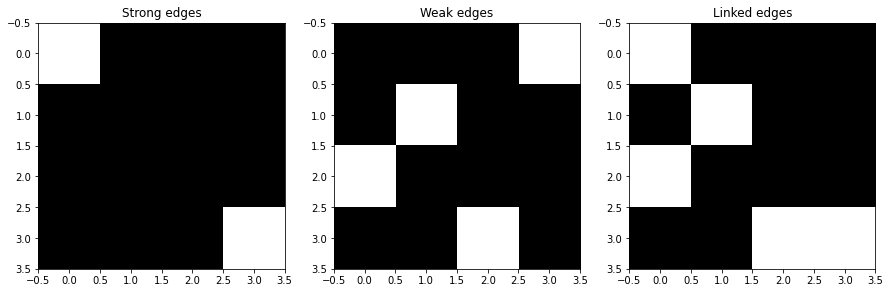

In [93]:
test_strong = np.array(
    [[1, 0, 0, 0],
     [0, 0, 0, 0],
     [0, 0, 0, 0],
     [0, 0, 0, 1]],
    dtype=np.bool
)

test_weak = np.array(
    [[0, 0, 0, 1],
     [0, 1, 0, 0],
     [1, 0, 0, 0],
     [0, 0, 1, 0]],
    dtype=np.bool
)

test_linked = link_edges(test_strong, test_weak)

plt.subplot(1, 3, 1)
plt.imshow(test_strong)
plt.title('Strong edges')

plt.subplot(1, 3, 2)
plt.imshow(test_weak)
plt.title('Weak edges')

plt.subplot(1, 3, 3)
plt.imshow(test_linked)
plt.title('Linked edges')
plt.show()

100%|██████████| 15080/15080 [01:56<00:00, 129.70it/s]


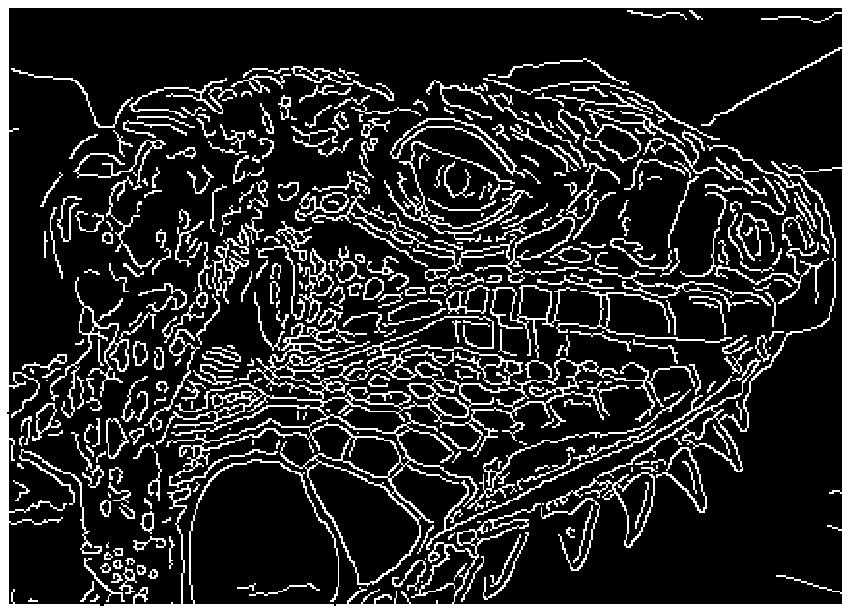

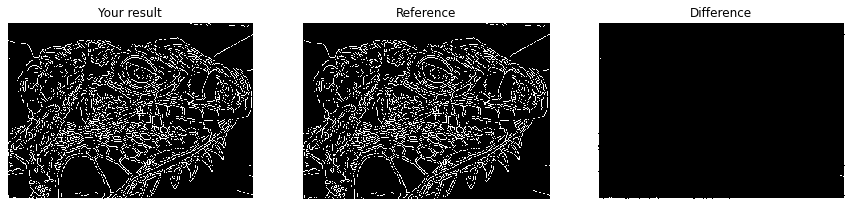

In [94]:
edges = link_edges(strong_edges, weak_edges)

plt.imshow(edges)
plt.axis('off')
plt.show()

plt.subplot(1, 3, 1)
plt.imshow(edges)
plt.axis('off')
plt.title('Your result')

plt.subplot(1, 3, 2)
reference = np.load('references/iguana_edge_tracking.npy')
plt.imshow(reference)
plt.axis('off')
plt.title('Reference')

plt.subplot(1, 3, 3)
plt.imshow(edges ^ reference)
plt.title('Difference')
plt.axis('off')
plt.show()

### 1.6 Детектор границ Кэнни (5 баллов)

Соберем вместе все, что сделали! 

Имплементируйте функцию **`canny`**, используя уже написанные функции. Поиграйтесь с параметрами, прокомментируйте результаты.

Вот пример работы алгоритма.

![iguana_edges.png](iguana_edges.png)

Здесь также будет предоставлено референсное изображение, убедитесь, что ваш алгоритм работает корректно.

In [98]:
def canny(img, kernel_size=5, sigma=1.4, high=20, low=15):
    """ Детектор границ Кэнни
    
    Используйте все ранее написанные функции.

    Args:
        img: image of shape (H, W).
        kernel_size: int of size for kernel matrix.
        sigma: float for calculating kernel.
        high: high threshold for strong edges.
        low: low threashold for weak edges.
    Returns:
        edge: numpy array of shape(H, W).
    """
    H, W = img.shape
    # edge = np.zeros((H, W), dtype=np.bool)

    kernel_size = 5
    sigma = 1.4
    low_threshold = 0.02
    high_threshold = 0.03


    kernel = gaussian_kernel(kernel_size, sigma)
    smoothed = conv(img, kernel)
    G, theta = gradient(smoothed)
    nms = non_maximum_suppression(G, theta)

    
    strong_edges, weak_edges = double_thresholding(nms, high_threshold, low_threshold)
    # edges=strong_edges * 1.0 + weak_edges * 0.5
    edges = link_edges(strong_edges, weak_edges)


    return edges



100%|██████████| 15080/15080 [01:55<00:00, 130.18it/s]
(310, 433)


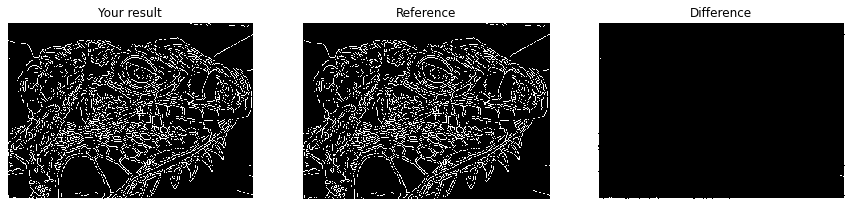

In [99]:
# Загружаем изображений
img = io.imread('iguana.png', as_gray=True)

# и запускаем детектор границ!
edges = canny(img, kernel_size=5, sigma=1.4, high=0.03, low=0.02)
print (edges.shape)

plt.subplot(1, 3, 1)
plt.imshow(edges)
plt.axis('off')
plt.title('Your result')

plt.subplot(1, 3, 2)
reference = np.load('references/iguana_canny.npy')
plt.imshow(reference)
plt.axis('off')
plt.title('Reference')

plt.subplot(1, 3, 3)
plt.imshow(edges ^ reference)
plt.title('Difference')
plt.axis('off')
plt.show()